In [1]:
import torch 
import torch_geometric
from torch_geometric.data import Data, DataLoader, InMemoryDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [80]:
trajectories = [np.load(f"../data/boids/raw/{f}") for f in os.listdir("../data/boids/raw") if f.endswith(".npy")]
print(len(trajectories))
print(trajectories[0].shape)

26
(1000, 25, 4)


# Autoregressive Latent Variable Models (AR-LVMs)
In this practical, we'll go over the following topics:
- Autoregressive Latent Variable Models and when to use them
- How to implement graph-based Autoregressive Latent Variable Models using pytorch/pytorch geometric
- Sensitivity Analysis

In the first section, we will build the Translational model from practical 1- so feel free to skip to the second part.

### Translational model

In [72]:
import time
class Trainer:
    def __init__(self, model, train_dataset, validation_dataset, batch_size=1, lr=0.0001, epochs=100, loss_fn=torch.nn.MSELoss(), model_name= "01-AR-Set-Model.pt"):
        """
        Simple Trainer class to train a PyTorch (geometric) model on a dataset.

        Args:
            model: PyTorch model to train
            train_dataset: PyTorch dataset to train on
            validation_dataset: PyTorch dataset to validate on
            batch_size: Batch size for training
            lr: Learning rate
            epochs: Number of epochs to train for
            loss_fn: Loss function to use
        """
        self.model = model
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.model_name = model_name

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Using device:", self.device)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        self.train_loader = self.make_data_loader(self.train_dataset)
        self.validation_loader = self.make_data_loader(self.validation_dataset, shuffle=False)

    def make_data_loader(self, dataset, shuffle=True):
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def train_loop(self):
        """
        Train loop for the model
        """
        best_model_loss = np.inf
        for epoch in range(self.epochs):
            # Train the model
            self.model.train()
            mean_train_loss = 0
            for i, data in enumerate(self.train_loader):
                data = self.train_dataset[i].to(self.device)
                self.optimizer.zero_grad()
                out = self.model(data)
                loss = self.loss_fn(out, data.y)
                loss.backward()
                self.optimizer.step()

                mean_train_loss += loss.item()
            mean_train_loss /= i
            
            # Validate the model
            self.model.eval()
            mean_val_loss = 0
            with torch.no_grad():
                for i, data in enumerate(self.validation_loader):
                    data = self.validation_dataset[i].to(self.device)
                    out = self.model(data)
                    loss = self.loss_fn(out, data.y)
                    mean_val_loss += loss.item()
                mean_val_loss /= i

            if mean_val_loss < best_model_loss:
                best_model_loss = mean_val_loss
                torch.save(self.model.state_dict(), f"../models/{self.model_name}")
            
            print(f"Epoch {epoch}, Mean Train Loss: {mean_train_loss}, Mean Validation Loss: {mean_val_loss}")



In [40]:
from tqdm import trange

class AR_Boids_Dataset(InMemoryDataset):
    def __init__(self, raw_data_path, processed_data_path, root=None, transform=None, pre_transform=None, post_transform=None, solution_idx_range=(0, 25), timesteps=1000, processed_file_name="AR3_Boids.pt", L = 1000):
        self.raw_data_path = raw_data_path
        self.processed_data_path = processed_data_path
        self.solution_idx_range = solution_idx_range
        self.timesteps = timesteps
        self.processed_file_name = processed_file_name
        self.pre_transform = pre_transform
        self.transform = transform
        self.post_transform = post_transform
        self.L = L
        super(AR_Boids_Dataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return [self.processed_file_name]

    @property
    def raw_file_names(self):
        return [pfn for pfn in os.listdir(self.raw_data_path) if (self.solution_idx_range[0] <= int(pfn.split("_")[-1][:-4]) < self.solution_idx_range[1])]
    
    def download(self):
        pass
    
    def __len__(self):
        return (self.timesteps - 1) * (self.solution_idx_range[1] - self.solution_idx_range[0])

    def pbc_distance(self, x1, x2, y1, y2):
        """
        Compute the distance between two points with periodic boundary conditions

        Args:
            x1 (float): x coordinate of point 1
            x2 (float): x coordinate of point 2
            y1 (float): y coordinate of point 1
            y2 (float): y coordinate of point 2
        
        Returns:
            float: Distance between the two points
        """
        dx = torch.abs(x1 - x2)
        dy = torch.abs(y1 - y2)
        dx = torch.min(dx, self.L - dx)
        dy = torch.min(dy, self.L - dy)
        return torch.sqrt(dx**2 + dy**2)

    def process(self):
        positions_list = []
        data_list = []
        for idx, raw_path in enumerate(self.raw_file_names):
            trajectory = np.load(self.raw_data_path + raw_path)

            if self.transform is not None:
                trajectory = self.transform(trajectory)
                
            # Add the initial positions to the positions list
            positions_list.append(trajectory[0, :, :2])

            for t in trange(trajectory.shape[0] - 1):
                # X is the current state: (Velocity x, Velocity y)
                # Y is the next state: (Delta Pos x, Delta Pos y, Delta Velocity x, Delta Velocity y)
                x = torch.tensor(trajectory[t], dtype=torch.float)
                y_temp = torch.tensor(trajectory[t+1], dtype=torch.float)
                # Right now y is (position x, position y, velocity x, velocity y) for the next timestep
                # However, we want delta position and delta velocity
                # Luckily, the delta poisition is just the velocity from the next timestep, and the delta velocity is the acceleration
                # So we can just take the last two elements of y to get the delta velocity
                # First we copy the last two columns of y to the first two columns of y
                y = y_temp.clone()
                y[:, :2] = y_temp[:, 2:]
                x_next = y_temp[:, 2:].clone()
                # Then we calculate the acceleration
                y[:, 2:] = y_temp[:, 2:] - x[:, 2:]
                edge_index = torch.tensor([[i, j] for i in range(trajectory.shape[1]) for j in range(trajectory.shape[1]) if i != j], dtype=torch.long).t().contiguous()
                edge_attr = torch.tensor([[self.pbc_distance(x[i, 0], x[j, 0], x[i, 1], x[j, 1])] for i in range(trajectory.shape[1]) for j in range(trajectory.shape[1]) if i != j], dtype=torch.float).t().contiguous()
                
                x = x[:, 2:]

                if self.post_transform is not None:
                    data = self.post_transform(data)
                
                data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr, x_next=x_next)
                data_list.append(data)
                
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_data_path+self.processed_file_name)
        torch.save(torch.tensor(positions_list), self.processed_data_path+"positions_"+self.processed_file_name)

    def __getitem__(self, idx):
        return self.get(idx)
    
    def __repr__(self):
        return f'{self.__class__.__name__}({len(self)})'

In [36]:
class TranslationalEquivariantModel(torch.nn.Module):
    def __init__(self, node_dim=2, emb_dim=16, out_dim=4):
        """
        Graph Neural Network that is equivariant to translations.

        Args:
            node_dim: Dimension of the node features
            emb_dim: Dimension of the node embeddings
            out_dim: Dimension of the output
        """
        super(TranslationalEquivariantModel, self).__init__()
        self.node_embedding = torch.nn.Linear(node_dim, emb_dim)
        self.conv1 = torch_geometric.nn.GCNConv(emb_dim, emb_dim, aggr='add')
        self.conv2 = torch_geometric.nn.GCNConv(emb_dim, out_dim, aggr='add')

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        edge_attr = edge_attr.view(-1)
        x = self.node_embedding(x)
        x = torch.nn.functional.relu(x)

        # If the edge attr > 40, set the edge attr to 0
        edge_attr[edge_attr > 40] = 0

        x = self.conv1(x, edge_index, edge_weight=edge_attr)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_attr)
        return x

In [41]:
equivariant_train_dataset = AR_Boids_Dataset(
    raw_data_path="../data/boids/raw/", 
    processed_data_path="../data/boids/processed/", 
    root="../data/boids/", 
    solution_idx_range=(0, 15), 
    timesteps=1000, 
    processed_file_name="AR3_Boids_Equivariant.pt"
    )

equivariant_validation_dataset = AR_Boids_Dataset(
    raw_data_path="../data/boids/raw/", 
    processed_data_path="../data/boids/processed/", 
    root="../data/boids/", 
    solution_idx_range=(16, 25), 
    timesteps=1000, 
    processed_file_name="AR3_VAL_Boids_Equivariant.pt"
    )

Processing...
100%|██████████| 999/999 [00:45<00:00, 22.08it/s]
Done!
Processing...
100%|██████████| 999/999 [00:45<00:00, 22.13it/s]
Done!


In [42]:
init_positions = torch.load("../data/boids/processed/positions_AR3_Boids_Equivariant.pt")
print(init_positions.shape)
init_val_positions = torch.load("../data/boids/processed/positions_AR3_VAL_Boids_Equivariant.pt")
print(init_val_positions.shape)

torch.Size([15, 25, 2])
torch.Size([9, 25, 2])


In [73]:
translational_equivariant_model = TranslationalEquivariantModel(emb_dim=64)
trainer = Trainer(translational_equivariant_model, equivariant_train_dataset, equivariant_validation_dataset, batch_size=8, loss_fn=torch.nn.MSELoss(), epochs=100, model_name="02-Translational-Equivariant-Model.pt")
trainer.train_loop()

Using device: cuda
Epoch 0, Mean Train Loss: 0.3644110172033783, Mean Validation Loss: 0.07490045399938312
Epoch 1, Mean Train Loss: 0.046123741681461786, Mean Validation Loss: 0.06986447185309452


KeyboardInterrupt: 

# Autoregressive Latent Variable Models
Recall that an LVM is a model that relates some observable variables $x$, to an unobserved *latent variable* z. The most popular LVM at the moment is the Variational Autoencoder by Kingma, et al. [1]. The VAE learns to reconstruct input $x$, by learning a variational posterior $q_\phi(z|x) \sim^{D_\text{KL}} p_\lambda(z)$ and a decoder $p_\theta(x|z)$ to reconstruct $x$ from $z$.

However, with dynamical systems we are looking to predict the next-state of the system $x^{t+1}$, from the current state $x^t$. This is a fundamentally different modeling task, since the posterior (and by extension the prior) will be conditioned on $x^t$. One approach for creating autoregressive LVMs is outlined in the *Equivariant Probabilistic Neural Simulation* (EPNS) paper [2]*. 

<img src="figures/EPNS.png" width=800 style="display: block; margin-left: auto; margin-right: auto; width: 50%;" />

<p style="display: block; margin-left: auto; margin-right: auto; width: 50%;">Figure 1: EPNS model overview</p>

 * : The EPNS framework can be used to create *equivariant distributions over trajectories*! For this practical we will only implement the base model (without E(n) equivariances like in practical 2).

## EPNS at a glance
Here, we will concisely explain what is shown in Figure 1, and how the model is trained. For descriptions on how to make this model equivariant, and more formal definitions, refer to the paper [2].

Components:
- Forward model $f_\theta(x^t) \rarr h^t$ : Also refered to as the processor; learned neural network with parameters $\theta$, used to create a node embedding of the input features $x^t$
- Conditional Prior $p_\theta(z|h^t)$ : The (conditional) prior distribution is a learned distribution over the latent space $z$, parameterized by a neural network with parameters $\theta$. This network takes the node embedding $h^t$ as input, and returns the mu's $\mu_i$ and sigma's $\sigma_i$ of the chosen distribution.
- Approximate Posterior $q_\phi(z|h^t, x^{t+1})$: The approximate posterior distribution is a learned distribution over hte latent space $z$, parameterized by a neural network with parameters $\phi$. This network takes the node embedding $h^t$, and next-step $x^{t+1}$ (embedding $h^{t+1}$) as input, and returns the mu's $\mu_i$ and sigma's $\sigma_i$ of the chosen distribution.
- Decoder $p_\theta(x^{t+1}|z, h^t)$: The decoder, with learned distribution $p_\theta(x^{t+1}|z, h^t)$ parameterized by a neural network with parameters $\theta$, learns to predict the next step $x^{t+1}$ given the latent variable $z$ and current-state embedding $h^t$. Note that unlike the VAE, there is a 'skip connection' that bypasses the prior/posterior and feeds $h^t$ into the decoder as well. This is done because the $z$'s are typically independently sampled, which may lead to unexpected behavior.

During training, we use all above neural networks as follows (Figure 1b):
- We forward $x^t$ through the forward model to get $h^t$
- We forward $h^t$ through the approximate posterior network, together with the next-state $x^{t+1}$. We store the distribution $q_\phi(z|h^t, x^{t+1})$ and sample $z$ from this distribution.
- Similarly, we forward $h^t$ through the conditional prior network and store the distribution $p_\theta(z|h^t)$.
- Next, we forward $h^t$ and $z$ through the decoder network, to get the predicted next-state $\hat{x}^{t+1}$.
- To update the parameters, we take the KL divergence between the posterior and prior: $D_\text{KL}(q_\phi(z|h^t, x^{t+1})||p_\theta(z|h^t))$ and the reconstruction loss (log probability or MSE) between $x^{t+1}$ and $\hat{x}^{t+1}$.
  - $\mathcal{L}_\text{EPNS} = D_\text{KL}(q_\phi(z|h^t, x^{t+1})||p_\theta(z|h^t)) - \mathbb{E}_{q_\phi(z|h^t, x^{t+1})} [p_\theta(x^{t+1} | z, x^t)]$

During inference/sampling, we no longer use the approximate posterior, since $x^{t+1}$ is of course unavailable. The process is as follows (Figure 1a):
- We forward $x^t$ through the forward model to get $h^t$
- We forward $h^t$ through the conditional prior network and store the distribution $p_\theta(z|h^t)$ and sample $z$ from this distribution.
- Next, we forward $h^t$ and $z$ through the decoder network, to get the predicted next-state $\hat{x}^{t+1}$.

Though similar to the 'standard' VAE, there are some notable differences to make it suitable for modeling dynamical systems.

#### Glossary to help read the code

 <table style="display: block; margin-left: auto; margin-right: auto; width: 50%;">
  <tr>
    <th colspan="2">Glossary</th>
  </tr>
  <tr>
    <th>Formal name</th>
    <th>Class name (in code)</th>
  </tr>
  <tr>
    <td>Forward model</td>
    <td>Processor()</td>
  </tr>
  <tr>
    <td>Approximate Posterior</td>
    <td>Encoder()</td>
  </tr>
  <tr>
    <td>Conditional Prior</td>
    <td>Prior()</td>
  </tr>
  <tr>
    <td>Decoder</td>
    <td>Decoder()</td>
  </tr>
</table> 

In [93]:
class ELBO_Loss(torch.nn.Module):
    def __init__(self, L):
        """
        Helper class to compute the ELBO loss for the AR-LVM model

        Args:
            L: size of the periodic boundary conditions
        """
        super(ELBO_Loss, self).__init__()
        self.L = L
    
    def forward(self, y_pred, y_true):
        """
        Forward pass of the ELBO loss.

        Args:
            y_pred: (q(z|h, x^t+1), p(z|h), p(x^t+1|z, h))
                each is a torch.Distribution object
            y_true: (x^t+1)

        ELBO is the sum of the KL divergence between the approximate posterior and the prior
        and the reconstruction loss
        = KL(q(z|h, x^t+1) || p(z|h)) - E_q(z|h, x^t+1)[log p(x^t+1|z, h)]

        Returns:
            torch.Tensor: ELBO loss
        """
        kl = torch.distributions.kl.kl_divergence(y_pred[0], y_pred[1]).mean(0).sum()  # mean over batch, sum over everything else
        recon = torch.nn.functional.mse_loss(y_pred[2].loc, y_true, reduction='sum') / y_true.shape[0] # mean over batch
        return kl + recon
        

class Encoder(torch.nn.Module):
    def __init__(self, num_layers=2, processor=None, emb_dim=64, latent_dim=16, nonlinearity = torch.nn.functional.relu):
        """
        Encoder for the AR-LVM model, takes in the node embeddings and returns a distribution over the latent space

        Args:
            num_layers: number of message passing layers
            processor: Processor model
            emb_dim: dimension of the node embeddings
            latent_dim: dimension of the latent space
            nonlinearity: activation function
        """
        super(Encoder, self).__init__()
        self.processor = processor
        self.mp_layers = torch.nn.ModuleList([torch_geometric.nn.GCNConv(emb_dim*2, emb_dim*2) for _ in range(num_layers)])
        self.fc_mu = torch.nn.Linear(emb_dim*2, latent_dim)
        self.fc_sigma = torch.nn.Linear(emb_dim*2, latent_dim)
        self.nonlinearity = nonlinearity
    
    def forward(self, h, edge_index, x_next, edge_attr):
        """
        Args:
            h: node embeddings
            edge_index: adjacency list
            x_next: next state

        Returns:
            torch.Distribution: Normal distribution over the latent space
        """
        h_next = self.processor(x_next, edge_index, edge_attr)

        h = torch.cat([h, h_next], dim=1)
        # Apply message passing layers
        for mp in self.mp_layers:
            h = mp(h, edge_index, edge_attr)
            h = self.nonlinearity(h)
        
        # Compute the mean and sigma
        mu = self.fc_mu(h)          # Create one z per node
        sigma = self.fc_sigma(h)    # Create one z per node
        sigma = torch.nn.functional.softplus(sigma) + 1e-6
        # Create a Normal distribution with mu and sigma
        enc_dist = torch.distributions.Normal(mu, sigma)
        return enc_dist
        
    
class Processor(torch.nn.Module):
    def __init__(self, num_layers=2, in_dim=4, emb_dim=64, nonlinearity = torch.nn.functional.relu):
        """
        Forward model, takes in the input data and returns the node embeddings

        Args:
            num_layers: number of message passing layers
            in_dim: input dimension
            emb_dim: dimension of the node embeddings
            nonlinearity: activation function
        """
        super(Processor, self).__init__()
        self.in_emb = torch.nn.Linear(in_dim, emb_dim)
        self.mp_layers = torch.nn.ModuleList([torch_geometric.nn.GCNConv(emb_dim, emb_dim) for _ in range(num_layers)])
        self.nonlinearity = nonlinearity


    def forward(self, x, edge_index, edge_attr):
        """
        Forward pass of the Processor

        Args:
            x: input data
            edge_index: adjacency list
            edge_attr: edge attributes

        Returns:
            torch.Tensor: node embeddings
        """
        h = self.in_emb(x)
        h = self.nonlinearity(h)

        for mp in self.mp_layers:
            h = mp(h, edge_index, edge_attr)
            h = self.nonlinearity(h)

        return h

    
class Decoder(torch.nn.Module):
    def __init__(self, num_layers=2, latent_dim=16, emb_dim=64, out_dim=4, nonlinearity = torch.nn.functional.relu, sigma = 0.1):
        """
        Decoder for the AR-LVM model, takes in the node embeddings and the latent variable z and returns a distribution over the output space,
        in this case the next timestep, with fixed variance.

        Args:
            num_layers: number of message passing layers
            emb_dim: dimension of the node embeddings
            out_dim: dimension of the output space
            nonlinearity: activation function
            sigma: fixed variance
        """
        super(Decoder, self).__init__()
        self.mp_layers = torch.nn.ModuleList([torch_geometric.nn.GCNConv(emb_dim+latent_dim, emb_dim+latent_dim) for _ in range(num_layers)])
        self.fc = torch.nn.Linear(emb_dim+latent_dim, out_dim)
        self.nonlinearity = nonlinearity
        self.sigma = sigma

    def forward(self, h, z, edge_index, edge_attr):
        """
        Forward pass of the Decoder. Concatenates the node embeddings and the latent variable z, then applies message passing layers
        and returns a Normal distribution over the output space

        Args:
            h: node embeddings
            z: latent variable
            edge_index: adjacency list
            edge_attr: edge attributes
        """
        # Concatenate h and z
        h = torch.cat([h, z], dim=1)
        # Apply message passing layers
        for mp in self.mp_layers:
            h = mp(h, edge_index, edge_attr)
            h = self.nonlinearity(h)
        # Apply the final linear layer
        out = self.fc(h)
        # Create a Normal distribution with the output and a fixed variance
        dec_dist = torch.distributions.Normal(out, self.sigma)
        return dec_dist
        

class Prior(torch.nn.Module):
    def __init__(self, num_layers=2, emb_dim=64, latent_dim=16, nonlinearity = torch.nn.functional.relu):
        """
        Prior class for the AR-LVM model, takes in the node embeddings and returns a distribution over the latent space

        Args:
            num_layers: number of message passing layers
            emb_dim: dimension of the node embeddings
            latent_dim: dimension of the latent space
            nonlinearity: activation function
        """
        super(Prior, self).__init__()
        self.mp_layers = torch.nn.ModuleList([torch_geometric.nn.GCNConv(emb_dim, emb_dim) for _ in range(num_layers)])
        self.fc_mu = torch.nn.Linear(emb_dim, latent_dim)
        self.fc_sigma = torch.nn.Linear(emb_dim, latent_dim)
        self.nonlinearity = nonlinearity
    
    def forward(self, h, edge_index, edge_attr):
        """
        Args:
            h: node embeddings
            edge_index: adjacency list
            edge_attr: edge attributes

        Returns:
            torch.Distribution: Normal distribution over the latent space
        """
        # Apply message passing layers
        for mp in self.mp_layers:
            h = mp(h, edge_index, edge_attr)
            h = self.nonlinearity(h)
        
        # Compute the mean and sigma
        mu = self.fc_mu(h)
        sigma = self.fc_sigma(h)
        sigma = torch.nn.functional.softplus(sigma) + 1e-6
        # Create a Normal distribution with mu and sigma
        prior_dist = torch.distributions.Normal(mu, sigma)
        return prior_dist


class AR_LVM_Model(torch.nn.Module):
    def __init__(self, encoder=None, processor=None, decoder=None, prior=None):
        super(AR_LVM_Model, self).__init__()
        self.encoder = encoder
        self.processor = processor
        self.decoder = decoder
        self.prior = prior
    
    def forward(self, data):
        """
        Forward pass of the AR-LVM model

        Args:
            data: torch_geometric.data.Data object
        
        Returns:
            tuple: (q(z|h, x^t+1), p(z|h), p(x^t+1|z, h))
                each is a torch.Distribution object
        """
        x, edge_index, x_next, edge_attr = data.x, data.edge_index, data.x_next, data.edge_attr
        edge_attr = edge_attr.view(-1)
        # If the edge attr > 40, set the edge attr to 0
        edge_attr[edge_attr > 40] = 0
        # Get the node embeddings
        h = self.processor(x, edge_index, edge_attr)
        # Get the Encoder distribution q(z|h, x^t+1)
        enc_dist = self.encoder(h, edge_index, x_next, edge_attr)
        z = enc_dist.rsample()
        # Get the Prior distribution p(z|h)
        prior_dist = self.prior(h, edge_index, edge_attr)
        # Get the Decoder distribution p(x^t+1|z, h)
        out = self.decoder(h, z, edge_index, edge_attr)
        # Return the distributions
        return (enc_dist, prior_dist, out)
    
    def sample(self, data):
        """
        Sample from the AR-LVM model

        Args:
            data: torch_geometric.data.Data object
        
        Returns:
            torch.Tensor: Sampled next state
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        edge_attr = edge_attr.view(-1)
        # If the edge attr > 40, set the edge attr to 0
        edge_attr[edge_attr > 40] = 0
        # Get the node embeddings
        h = self.processor(x, edge_index, edge_attr)
        # Get the Prior distribution p(z|h)
        prior_dist = self.prior(h, edge_index, edge_attr)
        z = prior_dist.rsample()
        # Get the Decoder distribution p(x^t+1|z, h)
        out = self.decoder(h, z, edge_index, edge_attr)
        return out.loc

In [76]:
torch.autograd.set_detect_anomaly(True)

processor = Processor(in_dim=2, num_layers=1) # NOTE: in_dim is 2 because we only have the velocity - VALIDATE THIS

ar_lvm_model = AR_LVM_Model(encoder=Encoder(num_layers=1, processor=processor), processor=processor, decoder=Decoder(num_layers=1), prior=Prior(num_layers=1))

loss_fn = ELBO_Loss(1000)
trainer = Trainer(ar_lvm_model, equivariant_train_dataset, equivariant_validation_dataset, loss_fn=loss_fn, batch_size=8, epochs=100, model_name="03-AR-LVM-Model.pt")

trainer.train_loop()

Using device: cuda
Epoch 0, Mean Train Loss: 1.774967452050751, Mean Validation Loss: 0.3149377712490616
Epoch 1, Mean Train Loss: 0.19119013004796553, Mean Validation Loss: 0.2889242496454254
Epoch 2, Mean Train Loss: 0.1835353067428176, Mean Validation Loss: 0.2802939283805016
Epoch 3, Mean Train Loss: 0.1804374621831004, Mean Validation Loss: 0.2750668296522443


KeyboardInterrupt: 

# Sensitivity Analysis

Probabilistic models are typically associated with stochastic domains, where there is a natural sense of probability. But this is not the full story. In particular, dynamical systems with high sensitivity are known to be another use-case for probabilistic models.

Here, high sensitivity refers to the variance in evolution depending on small perturbations of the input. A great example of a sensitive dynamical system is the double pendulum:

![Double Pendulum](figures/pendulum.gif)

Probabilistic models outperform their deterministic counterparts here, because the latter is known to be prone to 'averaging' diverging paths - often leading to physically inaccurate predictions. To illustrate this, let's go over a simple example.

### EXAMPLE:
Imagine we are investigating the diverging behavior of a double pendulum. Specifically, we want to compute the number of 'bounces' $Y$ after the full evolution of the system (eg after $T$ timesteps), depending on the initial configuration $X$.

We want to investigate some initial configurations that are very close to eachother $X_i \in X$. However, since they are very close, neural networks will often 'average' these into $\hat{x} = \mathbb{E}[X_i]$.*

From these experiments, we observe two likely outcomes: $P(Y=4|X=\hat{x})=0.5$ and $P(Y=2|X=\hat{x})=0.5$. 

A deterministic model $f_\text{det}: X \rarr Y$ will never be able to model this uncertainty - and is likely to predict the expected value $f_\text{det}(\hat{x}) \gets \mathbb{E}_{P(Y|X=\hat{x})}[ Y ] = 4 \cdot 0.5 + 2 \cdot 0.5 = 3$ which was never observed!

On the contrary, a probabilistic model would be able to learn this more naturally. An LVM $f_\text{lvm}: X  \rarr Y$ would be able to identify the diverging paths by splitting them into different values for latent variable $z$. Ie., $z=0$ for the first case and $z=1$ for the second case, st: $f_\text{lvm}(\hat{x}) \sim P_\lambda(Y|X,z)$. This is a much more natural way to model high-variance, highly sensitive dynamical systems.

*: An alternative source of uncertainty may come from human/measurement errors. Ie; When fixing $X=x$, due to human/measurement errors, a small bit of noise $\epsilon$ is always present, st the actual initial configuration $\hat{x} = x + \epsilon$.

### Sensitivity in the Boids setting
Similar to the double pendulum, Boids simulations can diverge completely with small changes to the input. The following figure is an example of this. 

![Boids Divergence](figures/positions_over_time.gif)

The figure shows the distributions of boid positions, over time for 1000 simulations with similar initial positions. Similarly to above, we took one initial state $x_0$ and created 1000 variants with small gaussian noise $\epsilon$ to the velocities and positions $\hat{x}_0 = x_0 + \epsilon$. As you can see, over time, the distributions have increasing standard deviations, and the means shift to the center of the box. Ie, we can observe high sensitivity wrt changes to the initial conditions of the simulation. As such, using a probabilistic model should increase the (physical) accuracy of predictions.


## Analysis

A simple analysis we can try here is we take the trained models (on the full dataset), and evaluate the velocity distributions per timestep on the $\hat{x}_0 = x_0 + \epsilon$ dataset (consisting of similar points, with small gaussian noise).

In [83]:
# Create dataset with only initial states of the sensitivity analysis data
def keep_01(data):
    return data[0:2, :, :]


initial_states_validation_dataset = AR_Boids_Dataset(
    raw_data_path="../data/boids_sensitivity/raw/", 
    processed_data_path="../data/boids_sensitivity/processed/", 
    root="../data/boids_sensitivity/", 
    solution_idx_range=(0, 10), 
    timesteps=2, 
    processed_file_name="AR3_SENS_init.pt",
    transform=keep_01
    )

Processing...
100%|██████████| 1/1 [00:00<00:00, 21.80it/s]
Done!


In [86]:
initial_positions = torch.load("../data/boids_sensitivity/processed/positions_AR3_SENS_init.pt")
print(initial_positions.shape)
sensitivity_trajectories = [np.load(f"../data/boids_sensitivity/raw/{f}") for f in os.listdir("../data/boids_sensitivity/raw") if f.endswith(".npy")]
print(len(sensitivity_trajectories))
print(sensitivity_trajectories[0].shape)

torch.Size([10, 25, 2])
10
(1000, 25, 4)


In [120]:
def pbc_distance(x1, x2, y1, y2, L=1000):
    """
    Compute the distance between two points with periodic boundary conditions

    Args:
        x1 (float): x coordinate of point 1
        x2 (float): x coordinate of point 2
        y1 (float): y coordinate of point 1
        y2 (float): y coordinate of point 2
    
    Returns:
        float: Distance between the two points
    """
    dx = torch.abs(x1 - x2)
    dy = torch.abs(y1 - y2)
    dx = torch.min(dx, L - dx)
    dy = torch.min(dy, L - dy)
    return torch.sqrt(dx**2 + dy**2)


def AR_LVM_rollout(model, data, timesteps=1000, initial_positions=None):
    """
    Rollout function for the AR-LVM model

    Args:
        model: AR-LVM model
        data: torch_geometric.data.Data object
        timesteps: number of timesteps to rollout
        initial_positions: initial positions of the nodes (position at t=0)
    """
    trajectory = np.empty((timesteps, data.x.shape[0], 4))
    trajectory[0, :, :2] = initial_positions
    trajectory[0, :, 2:] = data.x.cpu().numpy()
    for t in range(1, timesteps):
        current_velocities = trajectory[t-1, :, 2:]
        current_positions = trajectory[t-1, :, :2]
        with torch.no_grad():
            out = model.sample(data)
            # Out is the delta position and delta velocity for each node
            # Shape (25, 4)
            # We need to add the delta position to the previous position to get the new position
            # And add the delta velocity to the previous velocity to get the new velocity
            new_positions = current_positions + out.cpu().numpy()[:, :2]
            new_velocities = current_velocities + out.cpu().numpy()[:, 2:]
            trajectory[t, :, :2] = new_positions % 1000
            trajectory[t, :, 2:] = new_velocities
            data.x = torch.tensor(new_velocities, dtype=torch.float)
            new_positions = torch.tensor(new_positions, dtype=torch.float)
            data.edge_attr = torch.tensor([[pbc_distance(new_positions[i, 0], new_positions[j, 0], new_positions[i, 1], new_positions[j, 1])] for i in range(new_positions.shape[0]) for j in range(new_positions.shape[0]) if i != j], dtype=torch.float).t().contiguous()
            data.to(trainer.device)

    return trajectory
            
            

def AR_Translation_Equivariant_rollout(model, data, timesteps=1000, initial_positions=None):
    """
    Rollout function for the Translation Equivariant model

    Args:
        model: Translation Equivariant model
        data: torch_geometric.data.Data object
        timesteps: number of timesteps to rollout
        initial_positions: initial positions of the nodes (position at t=0)
    """
    trajectory = np.empty((timesteps, data.x.shape[0], 4))
    trajectory[0, :, :2] = initial_positions
    trajectory[0, :, 2:] = data.x.cpu().numpy()
    for t in range(1, timesteps):
        current_velocities = trajectory[t-1, :, 2:]
        current_positions = trajectory[t-1, :, :2]
        with torch.no_grad():
            out = model(data)
            # Out is the delta position and delta velocity for each node
            # Shape (25, 4)
            # We need to add the delta position to the previous position to get the new position
            # And add the delta velocity to the previous velocity to get the new velocity
            new_positions = current_positions + out.cpu().numpy()[:, :2]
            new_velocities = current_velocities + out.cpu().numpy()[:, 2:]
            trajectory[t, :, :2] = new_positions % 1000
            trajectory[t, :, 2:] = new_velocities
            data.x = torch.tensor(new_velocities, dtype=torch.float)
            new_positions = torch.tensor(new_positions, dtype=torch.float)
            data.edge_attr = torch.tensor([[pbc_distance(new_positions[i, 0], new_positions[j, 0], new_positions[i, 1], new_positions[j, 1])] for i in range(new_positions.shape[0]) for j in range(new_positions.shape[0]) if i != j], dtype=torch.float).t().contiguous()
            data.to(trainer.device)

    return trajectory

In [122]:
TE_rollouts = []

model = TranslationalEquivariantModel(emb_dim=64)
model.load_state_dict(torch.load("../models/02-Translational-Equivariant-Model.pt"))
model.eval()
model.to(trainer.device)

for i in range(10):
    print(f"Rollout {i}")
    data = initial_states_validation_dataset[i].to(trainer.device)
    trajectory = AR_Translation_Equivariant_rollout(model, data, timesteps=1000, initial_positions=initial_positions[i])
    TE_rollouts.append(trajectory)

Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9


In [118]:
LVM_rollouts = []

model = AR_LVM_Model(encoder=Encoder(num_layers=1, processor=processor), processor=processor, decoder=Decoder(num_layers=1), prior=Prior(num_layers=1))
model.load_state_dict(torch.load("../models/03-AR-LVM-Model.pt"))
model.eval()
model.to(trainer.device)


for i in range(10):
    print(f"Rollout {i}")
    data = initial_states_validation_dataset[i].to(trainer.device)
    init_pos = initial_positions[i]
    LVM_rollouts.append(AR_LVM_rollout(model, data, initial_positions=init_pos))

Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9


(10, 25, 2)
(500,)
(10, 25, 2)
(500,)
(26, 25, 2)
(1300,)
(10, 25, 2)
(500,)
(10, 25, 2)
(500,)
(26, 25, 2)
(1300,)
(10, 25, 2)
(500,)
(10, 25, 2)
(500,)
(26, 25, 2)
(1300,)
(10, 25, 2)
(500,)
(10, 25, 2)
(500,)
(26, 25, 2)
(1300,)
(10, 25, 2)
(500,)
(10, 25, 2)
(500,)
(26, 25, 2)
(1300,)


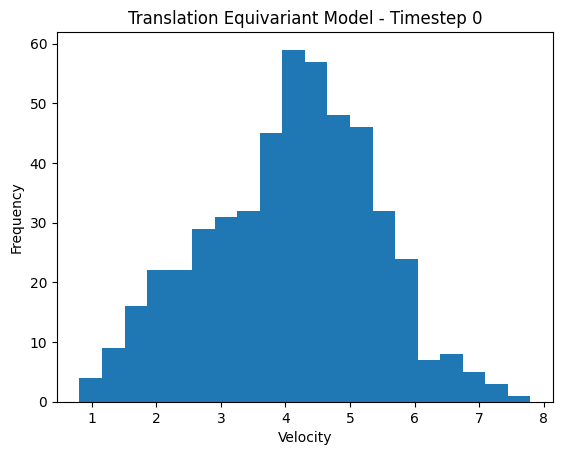

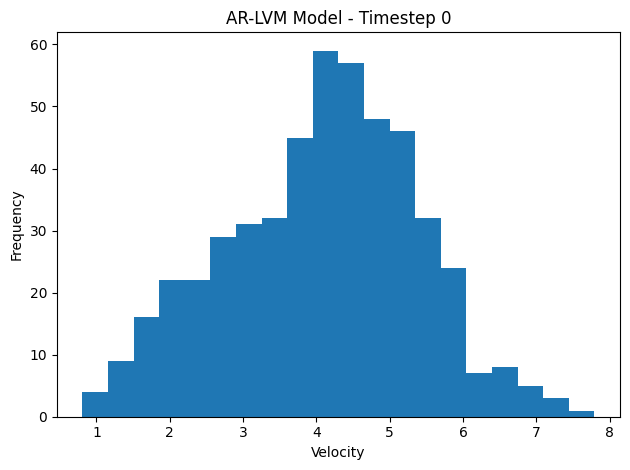

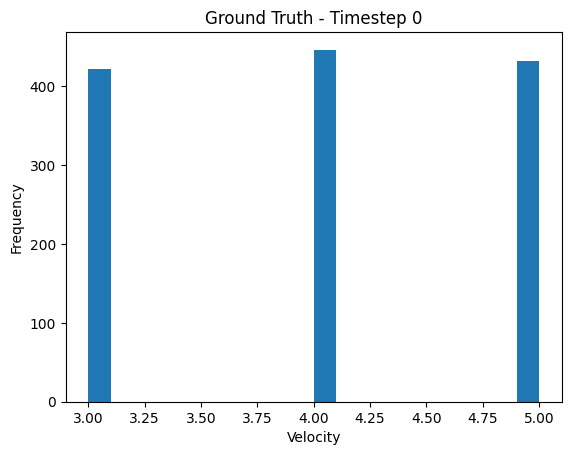

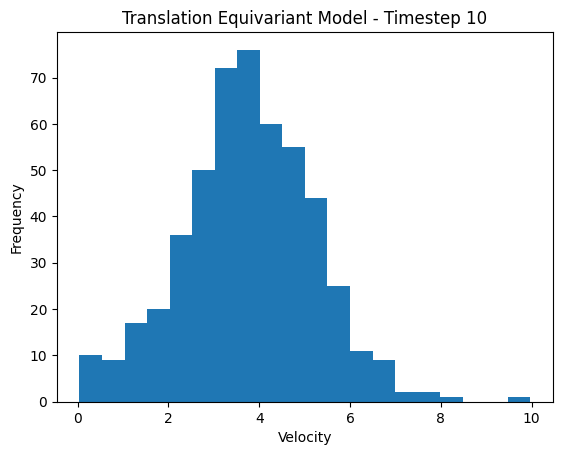

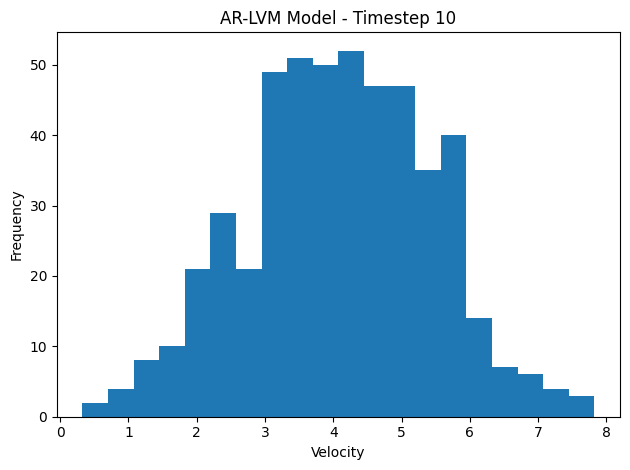

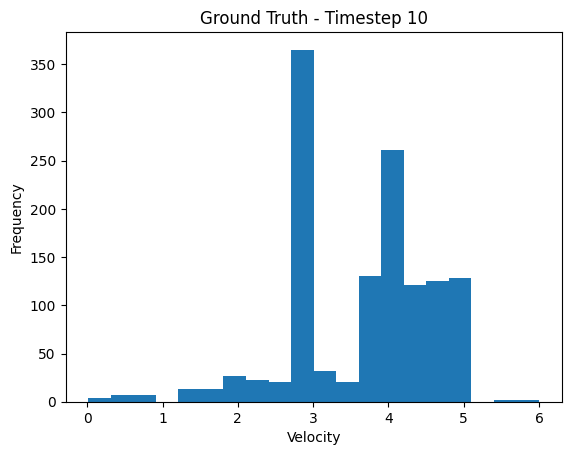

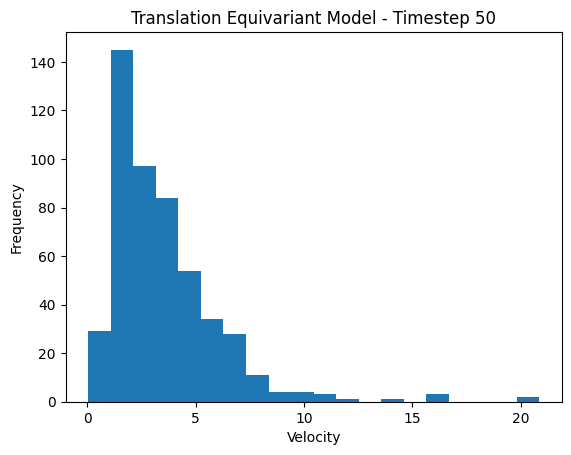

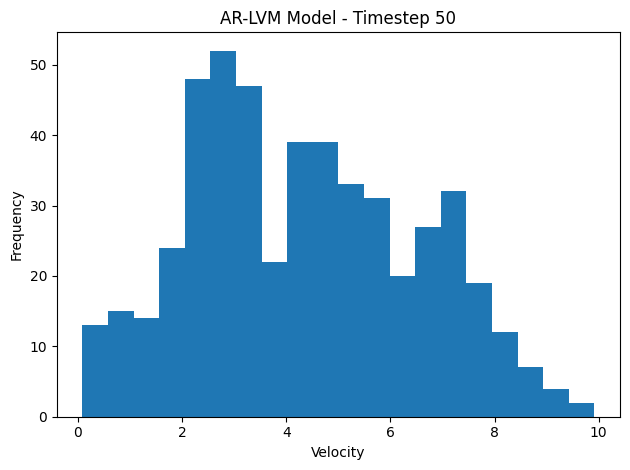

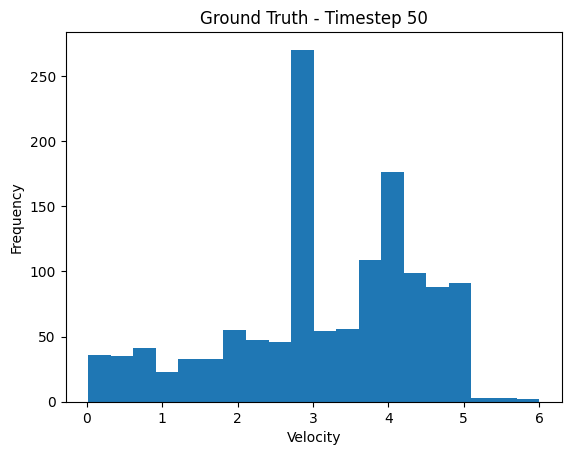

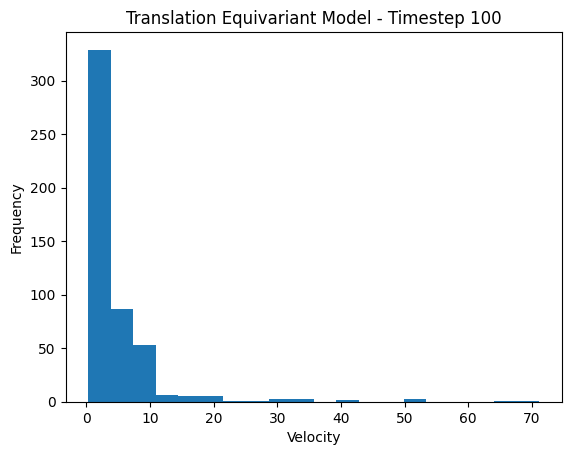

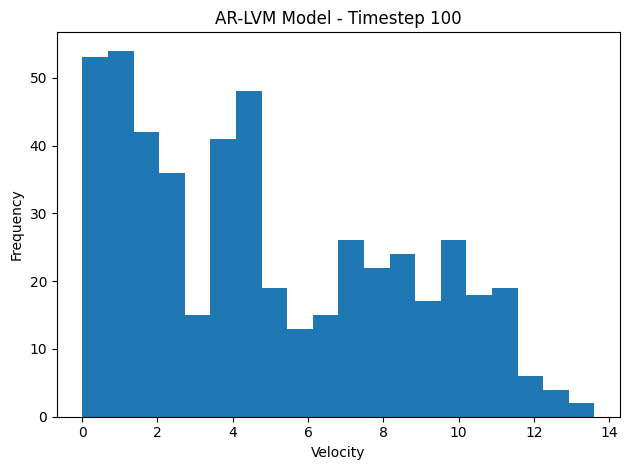

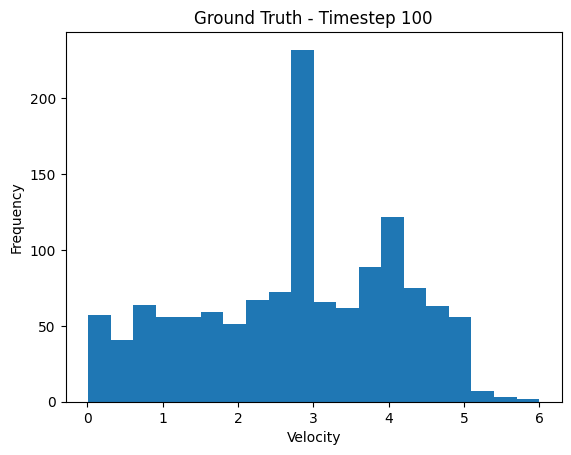

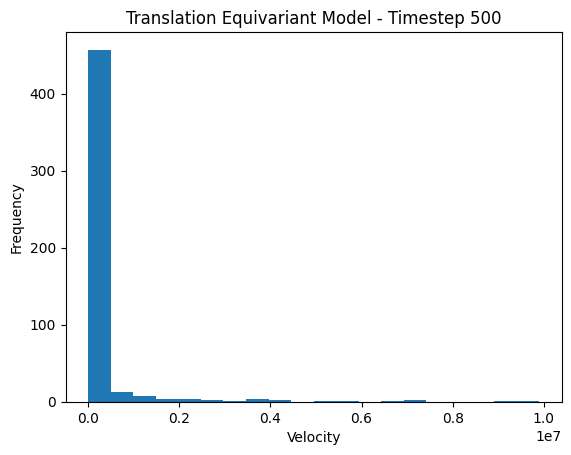

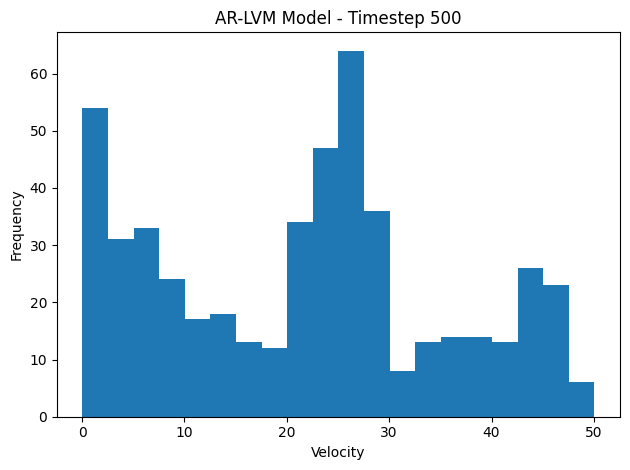

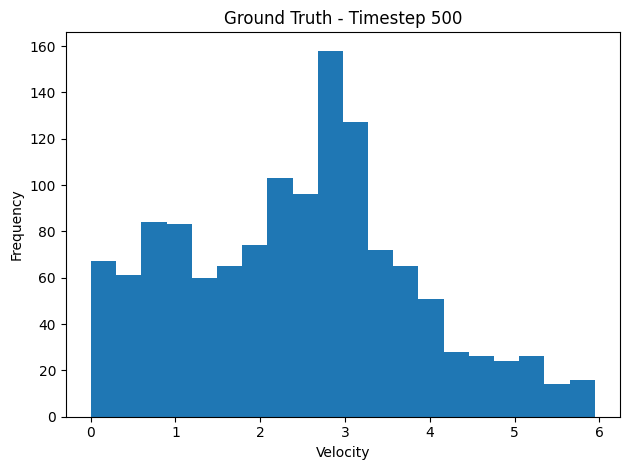

In [136]:
def velocity_histogram_t(trajectories, t):
    """
    Plot the histogram of the velocities at a given timestep

    Args:
        trajectories: List of trajectories
        t: Timestep to plot
    """
    velocities = np.array([trajectory[t, :, 2:] for trajectory in trajectories])
    print(velocities.shape)
    # Treat x and y velocities the same, by creating one column
    velocities = velocities.reshape(-1, 2)
    velocities = velocities.reshape(-1)
    print(velocities.shape)
    velocities = np.abs(velocities)
    fig, ax = plt.subplots()
    ax.hist(velocities, bins=20)
    ax.set_xlabel("Velocity")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Velocity Histogram at Timestep {t}")
    return fig, ax

for i, t in enumerate([0, 10, 50, 100, 500]):
    fig, ax = velocity_histogram_t(TE_rollouts, t)
    ax.set_title(f"Translation Equivariant Model - Timestep {t}")
    fig, ax = velocity_histogram_t(LVM_rollouts, t)
    ax.set_title(f"AR-LVM Model - Timestep {t}")
    plt.tight_layout()
    fig, ax = velocity_histogram_t(trajectories, t)
    ax.set_title(f"Ground Truth - Timestep {t}")

plt.tight_layout()
plt.show()

### What can we learn from this?

The thing that is immediately obvious is that the models suffer from exploding value problems over long rollouts*. Especially the deterministic model. This is likely because they were trained only trained to predict one step ahead. A proven technique to mitigate such problems is to utilize _pushforward training_ (Multi-step training). Essentially, during training, the model creates a rollout of multiple steps(autoregressively), and the loss is computed over the final state. 
* Another reason may be the lack of preprocessing done here. The distances between nodes can be very large, and the velocities (though bounded in the simulator) are unbounded.

One interesting observation for the shorter rollouts (t=10, 50) is that the LVM can learn multimodal distributions better than the deterministic model. The LVM has multiple 'peaks' and a more equal probability mass distribution than the deterministic model, which is in-line with our expectations.

#### Fin

We hope these notebooks were useful to you! 

Since this is the first edition of the 'revamped' course, make sure to give us feedback on what you liked/disliked about the course - so we can make it even better in the future.

![robot dance](https://coolmaterial.com/wp-content/uploads/2020/12/Boston-Dynamics-Robots-Dance.gif)


## References
[1] Kingma, D. P. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.

[2] Minartz, K., Poels, Y., Koop, S., & Menkovski, V. (2024). Equivariant neural simulators for stochastic spatiotemporal dynamics. Advances in Neural Information Processing Systems, 36.